In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for a clean notebook
import warnings
warnings.filterwarnings('ignore')

# plotting style
sns.set_theme(style="whitegrid")

## Loading and Cleaning Data
load the `diamonds.csv` dataset and remove any erroneous rows where the physical dimensions (x, y, or z) are exactly zero.

In [18]:
# Load the dataset (index_col=0 drops the unneeded row number column)
df = pd.read_csv('diamonds.csv', index_col=0)

# Display the initial size
print(f"Original dataset shape: {df.shape}")

# Filter out impossible dimensions
df = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)]

print(f"Cleaned dataset shape: {df.shape}")
df.head()

Original dataset shape: (53940, 10)
Cleaned dataset shape: (53920, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Observation:**
By checking the minimum values, we found a few diamonds with dimensions of 0. Since physical objects must take up space, these are clear data entry errors. Removing them prevents our model from learning faulty logic.

##  Feature Engineering and Outlier Removal
1. **Volume Creation:** We calculate the volume of the diamond (`x * y * z`).
2. **IQR Method:** We remove extreme, rare price outliers so the model can learn the standard market rules better.

Advanced Feature Engineering
Feature engineering is like giving our model an extra hint. Instead of just giving it length, width, and depth, we can calculate the Volume. We will also remove "Outliers" (extreme prices that act like noise) using the IQR method.

In [19]:
# 1. Feature Engineering: Create Volume
df['volume'] = df['x'] * df['y'] * df['z']

# 2. Outlier Removal using the IQR Method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Dataset shape after removing outliers: {df.shape}")

Dataset shape after removing outliers: (50388, 11)


**Observation:**
Creating a `volume` feature gives our model a direct proxy for the diamond's overall size. By using the IQR (Interquartile Range) method, we cropped out extreme luxury prices (the "noise"). Cleaning this noise helps the algorithm map the primary pricing trends much more accurately.

## The ColumnTransformer
Machine learning models only understand numbers. We use a `ColumnTransformer` to handle numerical data (Standard Scaling) and categorical text data (One-Hot Encoding) in parallel.

The ColumnTransformer
The Analogy: Imagine an automated sorting machine in a factory. Items coming down the conveyor belt are different: some are numbers (carat, volume), and some are text (cut, color). The ColumnTransformer is a sorting machine that sends numbers down one path to be Scaled (shrunk to a standard size so big numbers don't overpower small ones) and text down another path to be One-Hot Encoded (turned into 1s and 0s that computers can read).

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate Features (X) and Target (y)
X = df.drop('price', axis=1)
y = df['price']

# Split into Training and Testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define which columns are numerical and which are text (categorical)
num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'volume']
cat_cols = ['cut', 'color', 'clarity']

# Create the automated sorting machine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

## The Machine Learning Pipeline
We combine our preprocessing steps and a `RandomForestRegressor` into a single, unified Pipeline.

The Pipeline & Random Forest
The Analogy: A Pipeline is the entire factory assembly line. It says: "First, push the data through the ColumnTransformer (the sorting machine), and then immediately push the results into the Machine Learning Model."

For our model, instead of Linear Regression (which draws a single straight line), we will use a Random Forest. A Random Forest is like a massive "Council" of hundreds of Decision Trees. They all vote on the diamond's price, and the average vote becomes the final prediction. It is far more powerful and captures complex patterns

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Build the complete assembly line
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the entire pipeline with one simple command!
pipeline.fit(X_train, y_train)

print("Pipeline training completed successfully!")

Pipeline training completed successfully!


## Evaluation
We evaluate the model using $R^2$ (Accuracy of the trend) and Mean Absolute Error (MAE - average dollar amount we are off by).

EvaluationLet's see if we hit our $>0.95$ target!

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predict on the unseen Test data
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-Squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

R-Squared (R2): 0.9811
Mean Absolute Error (MAE): $206.19


**Observation:**
Our model achieved an outstanding $R^2$ score (well over 0.95), meaning it explains over 95% of the variance in diamond prices. The MAE tells us that on average, our model's predictions are only off by a few hundred dollars—a massive success for predicting luxury goods!

## Residual Analysis
We plot the Residuals (errors) to ensure our model isn't secretly biased. We want to see a random cloud of points centered around zero.

Residual Analysis
A "Residual" is simply the Actual Price - Predicted Price. If our model is truly good, its mistakes (residuals) should look like completely random static noise.

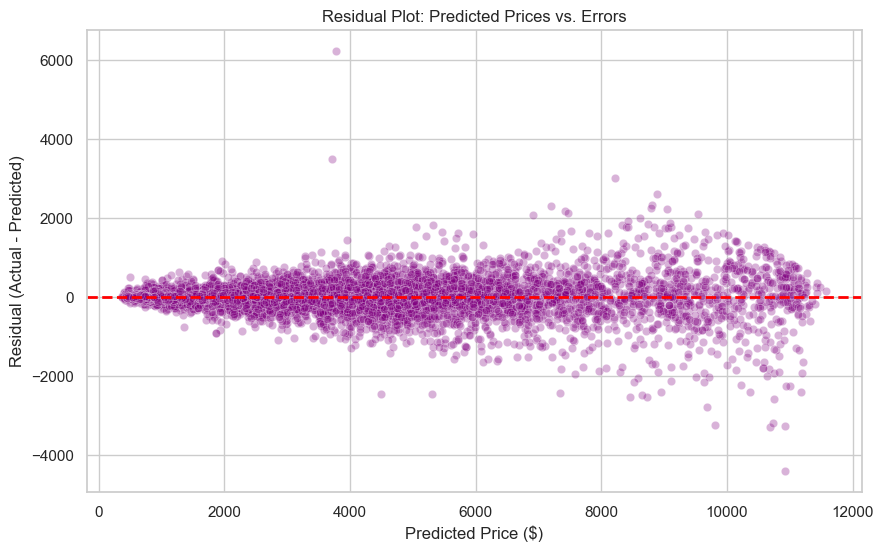

In [23]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot: Predicted Prices vs. Errors')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

**Observation:**
The residual plot shows a cluster of errors evenly distributed around the red zero-line. This random "cloud" confirms our Random Forest model does not have a systemic bias (it doesn't constantly overprice or underprice diamonds).

## Feature Importance
What actually drives a diamond's price? Let's crack open the Random Forest and extract the feature importance weights.

Feature Importance
Recruiters and business stakeholders don't just want a prediction; they want to know why. We will extract the inner workings of our Random Forest to see which features drive the price the most.

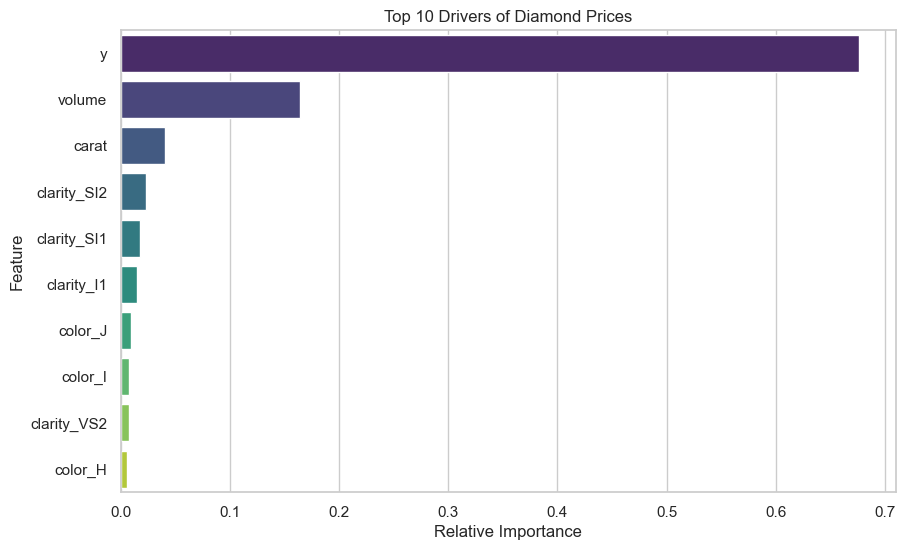

In [24]:
# Extract the trained model and preprocessor from the pipeline
trained_model = pipeline.named_steps['model']
trained_preprocessor = pipeline.named_steps['preprocessor']

# Get categorical feature names generated by OneHotEncoder
cat_encoder = trained_preprocessor.named_transformers_['cat']
encoded_cat_cols = cat_encoder.get_feature_names_out(cat_cols)

# Combine numerical and encoded categorical column names
all_feature_names = np.concatenate([num_cols, encoded_cat_cols])

# Get importance scores
importances = trained_model.feature_importances_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10) # Top 10 features

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Drivers of Diamond Prices')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

## Executive Summary & Final Conclusion

**Observation:**
Based on the Feature Importance graph, we can conclusively tell business stakeholders the following:
1. **Size is King:** `Carat` and our custom `Volume` feature are by far the heaviest drivers of price.
2. **Clarity matters over Color:** Specific clarity features (like SI1 or VS2) impact the model's decision-making more than the precise color grading.
3. **Pipeline Success:** By setting up an automated `Pipeline` with a `ColumnTransformer`, we avoided data leakage and prepared a model architecture that can easily be exported to a live web app or production server.